In [9]:
from eda import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    Input,
    Flatten,
    GlobalMaxPooling1D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import shuffle
import random
import os
seed = 777
# Set the seed for random number generation in Python
random.seed(seed)

# Set the seed for NumPy
np.random.seed(seed)

# Set the seed for TensorFlow
tf.random.set_seed(seed)

# Force TensorFlow to use deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [10]:
file_path = './data_preprocessing/binary_classification'

all_files = glob.glob(os.path.join(file_path, '*.csv'))

# Initialize lists to hold individual train and test DataFrames
test_list = []
train_list = []
# Loop over all files and read them
for filename in all_files:
    # Extract hotel name from filename
    hotel_name = os.path.basename(filename).replace('_input_data.csv', '')  # Removes directory and specific file extension
    temp_df = pd.read_csv(filename)
    temp_df['hotel'] = hotel_name  # Add a column for hotel name
    
    # Perform train-test split for each hotel's data
    train_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['label'], random_state=42)
    
    # Append the resulting DataFrames to the lists
    train_list.append(train_df)
    test_list.append(test_df)

# Concatenate all test DataFrames into one for final test data
test_data = pd.concat(test_list, ignore_index=True)
train_data = pd.concat(train_list, ignore_index=True)
# Shuffle the combined train and test data
train_data = shuffle(train_data, random_state=42)
test_data = shuffle(test_data, random_state=42)
# Concatenate all DataFrames into one
data = pd.read_csv('./data_preprocessing/kaggle/input_data.csv')
data['label'] = data['label'].apply(lambda x: 1 if x > 0.5 else 0)
# Combine df_test to data
data = pd.concat([data, train_data], ignore_index=True)
# Shuffle the combined DataFrame
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)


label
1    21402
0     3749
Name: count, dtype: int64


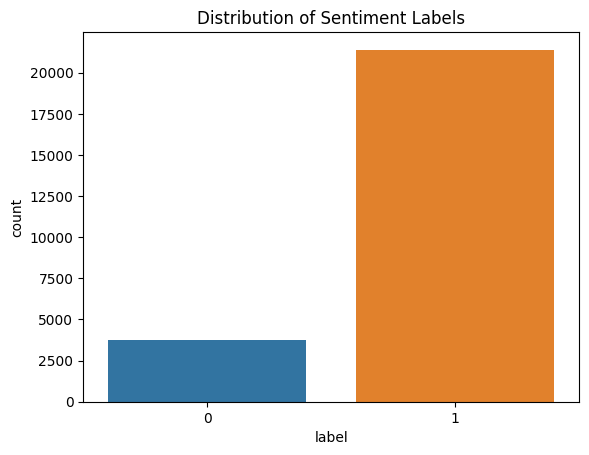

In [11]:
print(data['label'].value_counts())
# Distribution of labels
sns.countplot(x='label', data=data)
plt.title('Distribution of Sentiment Labels')
plt.show()

In [12]:
# Features and labels
X_train = data[['cleaned_content', 'Review Content', 'normalized_score']]
y_train = data['label']
X_test = test_data[['cleaned_content', 'Review Content', 'normalized_score']]
y_test = test_data['label']

# Reset index after splitting
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Perform the split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Reset index after splitting
X_train = X_train.reset_index(drop=True)
X_val = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_test.reset_index(drop=True)

# Display the distribution of labels in training and testing sets
print("Training label distribution:\n", y_train.value_counts())
print("\nTesting label distribution:\n", y_test.value_counts())
print("\nValidation label distribution:\n", y_val.value_counts())


Training label distribution:
 label
1    17121
0     2999
Name: count, dtype: int64

Testing label distribution:
 label
1    1782
0     231
Name: count, dtype: int64

Validation label distribution:
 label
1    1782
0     231
Name: count, dtype: int64


In [13]:
# Check for empty strings or strings that only contain spaces in 'cleaned_content' column
empty_or_space_strings = X_train['cleaned_content'].apply(lambda x: x.strip() == '')

# Get the indices of such rows
indices = empty_or_space_strings[empty_or_space_strings].index

# Print the indices and the corresponding rows
print(f"Indices of rows with empty or space-only strings: {indices.tolist()}")
print(X_train.loc[indices])

Indices of rows with empty or space-only strings: []
Empty DataFrame
Columns: [cleaned_content, Review Content, normalized_score]
Index: []


In [14]:
import pandas as pd
from sklearn.utils import shuffle

# First, identify minority classes in y_train
class_distribution = y_train.value_counts()
max_class_count = class_distribution.max()
minority_class = class_distribution[class_distribution < max_class_count].index.tolist()

# Define a list to store the augmented data
augmented_data = []

# Loop through minority classes and augment their data
for cls in minority_class:
    # Select rows belonging to the current minority class
    minority_class_data = X_train[y_train == cls].reset_index(drop=True)
    
    # Calculate how many samples are needed to balance the class
    num_samples_needed = max_class_count - class_distribution[cls]
    
    # Calculate how many augmentations per sample are needed
    num_aug = 3
    # max(1, num_samples_needed // len(minority_class_data))
    
    # Augment the data for the minority class
    for i in range(len(minority_class_data)):
        sentence = minority_class_data['cleaned_content'][i]
        
        # Apply the eda function with num_aug as the augmentation parameter
        augmented_sentences = eda(sentence, num_aug=num_aug)
        
        # For each augmented sentence, append it along with its label
        for augmented_sentence in augmented_sentences:
            augmented_data.append({'cleaned_content': augmented_sentence, 'label': cls})

# Convert the augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Add the augmented data to your original X_train and y_train
X_train = pd.concat([X_train, augmented_df[['cleaned_content']]], ignore_index=True)
y_train = pd.concat([y_train, augmented_df['label']], ignore_index=True)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=seed)

# Display the new class distribution
print("New training label distribution:\n", y_train.value_counts())


New training label distribution:
 label
1    17121
0    14995
Name: count, dtype: int64


In [15]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)

# Apply random under sampling
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Display the new class distribution
print("Resampled training label distribution:\n", y_resampled.value_counts())

Resampled training label distribution:
 label
0    14995
1    14995
Name: count, dtype: int64


count    32116.000000
mean        92.117947
std         90.526748
min          7.000000
25%         38.000000
50%         68.000000
75%        112.000000
max       1654.000000
Name: cleaned_content, dtype: float64


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


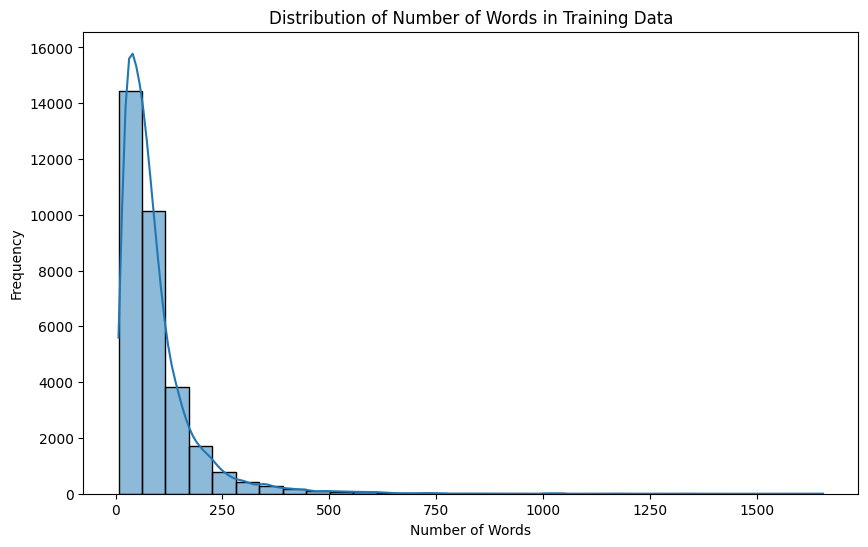

In [16]:
# Calculate the number of words in each review in the training data
word_counts = X_train['cleaned_content'].apply(lambda x: len(x.split()))
# Display basic statistics
print(word_counts.describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=30, kde=True)
plt.title('Distribution of Number of Words in Training Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [17]:
def preprocess_text(texts, tokenizer, max_sequence_length = 100):
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences to the same length
    sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return sequences_padded

In [18]:

from keras.preprocessing.sequence import pad_sequences

# Combine training and testing texts for fitting the tokenizer
texts = X_train['cleaned_content']

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Calculate the median length of the words in X_train['cleaned_content']
word_lengths = X_train['cleaned_content'].apply(lambda x: len(x.split()))
max_sequence_length = int(np.mean(word_lengths))
print(f"Max sequence length: {max_sequence_length}")

X_train_padded = preprocess_text(X_train['cleaned_content'], tokenizer, max_sequence_length)
X_test_padded = preprocess_text(X_test['cleaned_content'], tokenizer, max_sequence_length)
X_val_padded = preprocess_text(X_val['cleaned_content'], tokenizer, max_sequence_length)

print(len(X_train_padded), len(X_test_padded), len(X_val_padded))

Max sequence length: 92
32116 2013 2013


In [19]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Prepare sentences for Word2Vec
sentences = [text.split() for text in texts]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=max_sequence_length, window=5, min_count=1, workers=4)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_dim = max_sequence_length
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True
))
# Add a convolutional layer followed by max pooling
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                 kernel_regularizer=l2(0.0001)
                 ))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False, 
                            kernel_regularizer=l2(0.0001), 
                            dropout=0.3
                            )))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [22]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=15,
    batch_size=300,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping]
)   


Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.6014 - loss: 0.6915 - val_accuracy: 0.8490 - val_loss: 0.4526
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7535 - loss: 0.5504 - val_accuracy: 0.7938 - val_loss: 0.5058
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8210 - loss: 0.4286 - val_accuracy: 0.8162 - val_loss: 0.4545
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8345 - loss: 0.3979 - val_accuracy: 0.8172 - val_loss: 0.4509
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8475 - loss: 0.3807 - val_accuracy: 0.8291 - val_loss: 0.4256
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8544 - loss: 0.3659 - val_accuracy: 0.8321 - val_loss: 0.4100
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8569 - loss: 0.3565 - val_accuracy: 0.8346 - val_loss: 0.4085
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.8610 - loss: 0.3468 - val_a

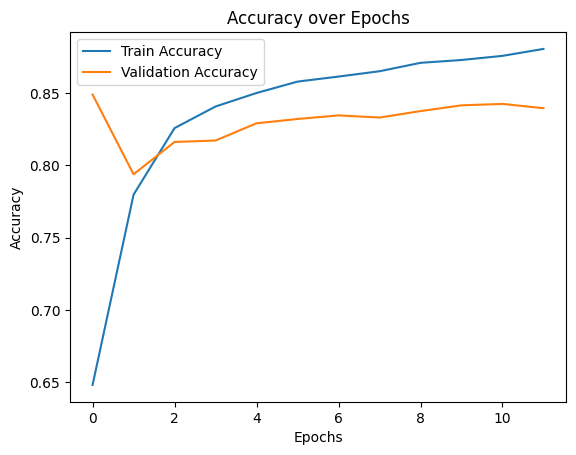

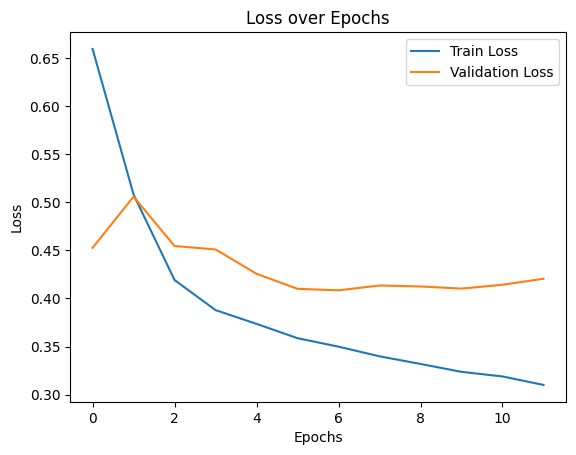

In [23]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# Predict on test data
y_pred_prob = model.predict(X_test_padded)



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [25]:
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.39      0.81      0.53       231
    Positive       0.97      0.84      0.90      1782

    accuracy                           0.83      2013
   macro avg       0.68      0.82      0.71      2013
weighted avg       0.90      0.83      0.86      2013



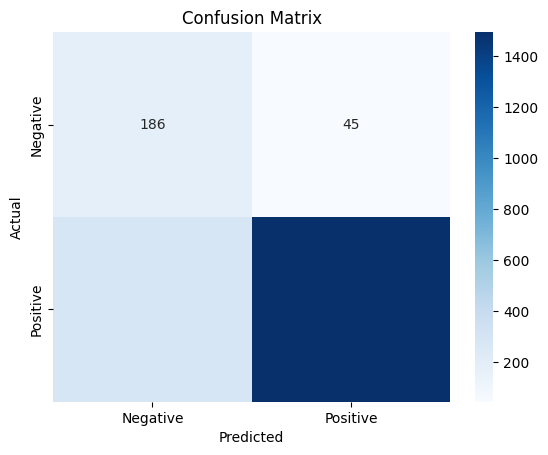

[[ 186   45]
 [ 288 1494]]


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(cm)

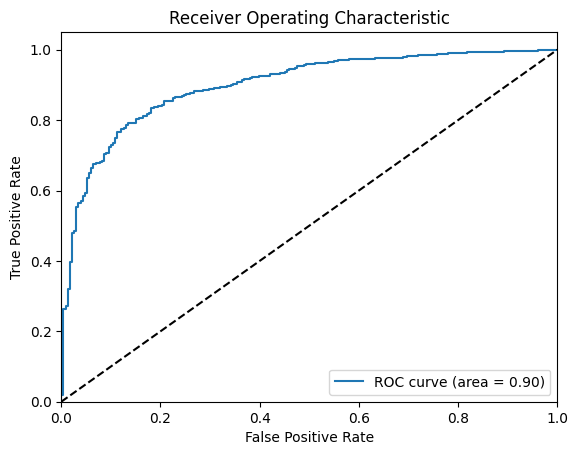

ROC-AUC Score: 0.8977558169477361


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Score:", roc_auc)


In [31]:
# Check if 'predicted_scores' column exists in test_data
print(test_data.columns)

Index(['Review Provider', 'Review ID', 'Review Content', 'Review Score',
       'Review Time', 'normalized_score', 'Hotel', 'cleaned_content', 'label',
       'hotel', 'predicted_scores'],
      dtype='object')


Processing hotel: jpark_island_resort_and_waterpark
Number of records for jpark_island_resort_and_waterpark: 104


C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


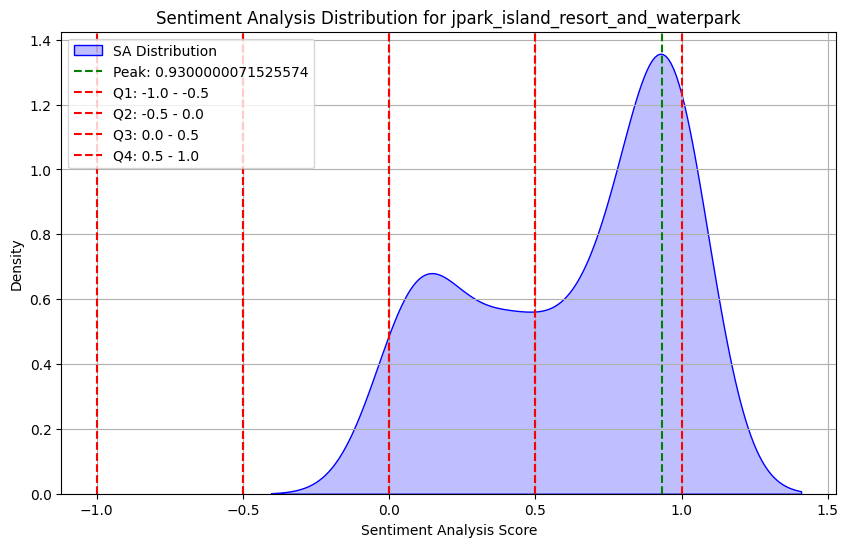

KS Statistic (Normal): 0.5043155039791788, P-value (Normal): 5.149395448775481e-25
KS Statistic (Uniform): 0.2941195460466238, P-value (Uniform): 1.816410333413817e-08


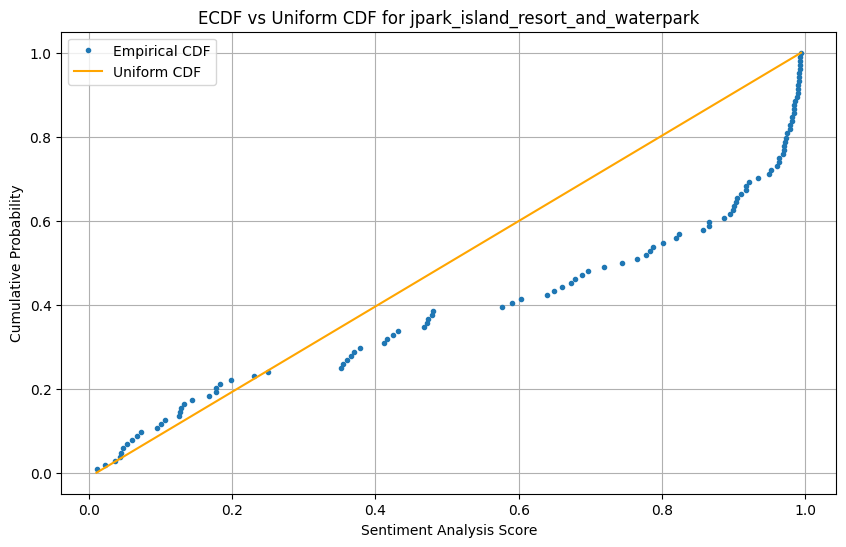

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


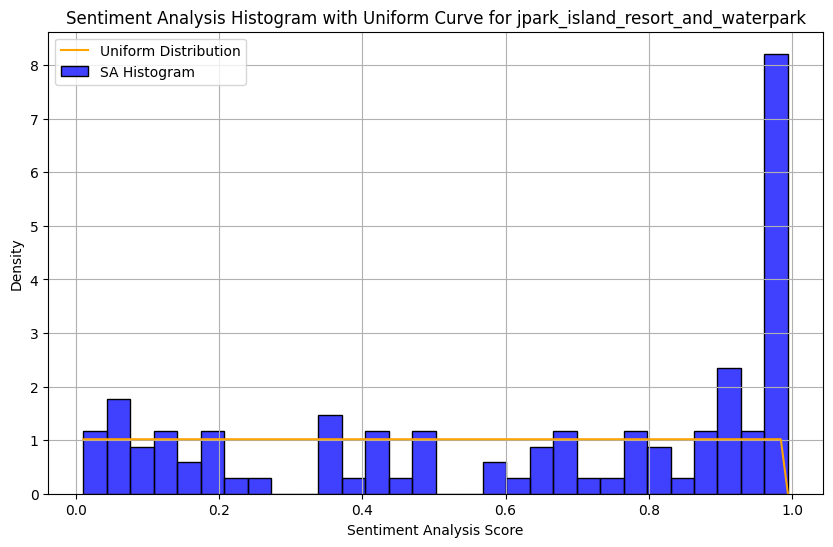

C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Processing hotel: bai_hotel
Number of records for bai_hotel: 797


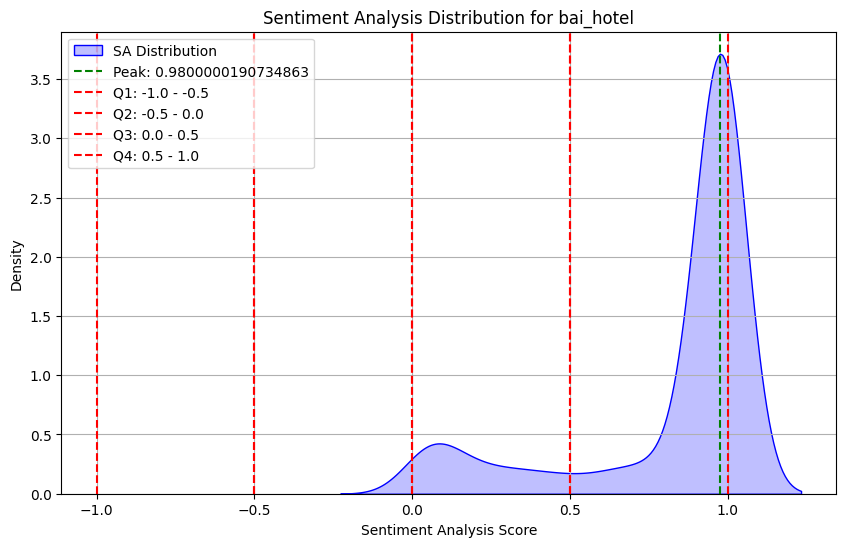

KS Statistic (Normal): 0.567330854597851, P-value (Normal): 7.374589397788742e-243
KS Statistic (Uniform): 0.6464032677365665, P-value (Uniform): 0.0


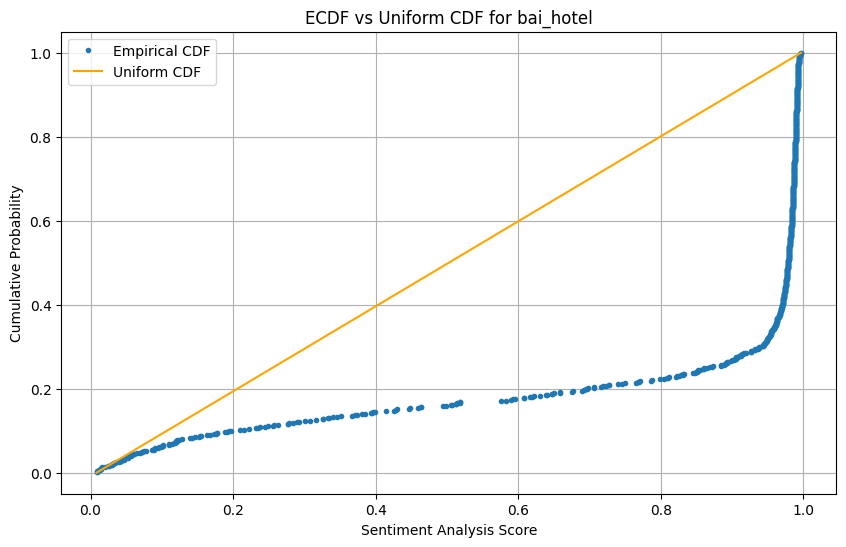

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


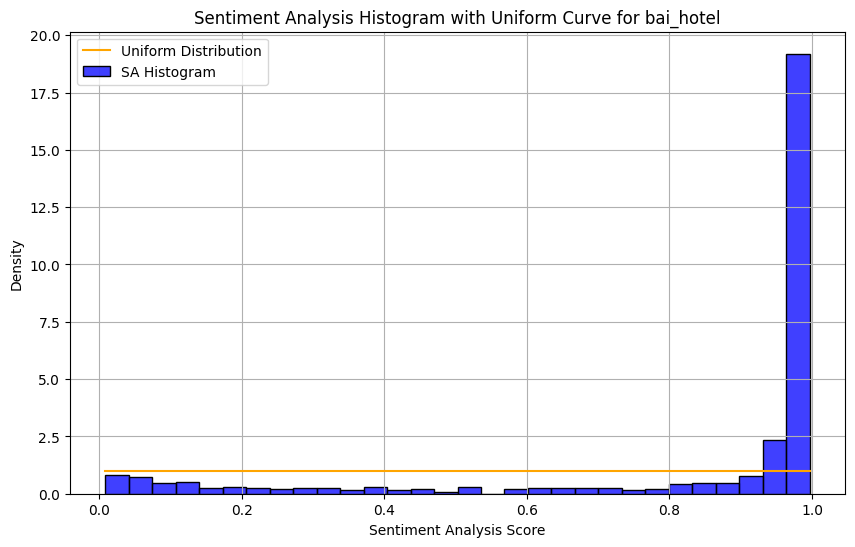

C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Processing hotel: seda_ayala_center_cebu
Number of records for seda_ayala_center_cebu: 365


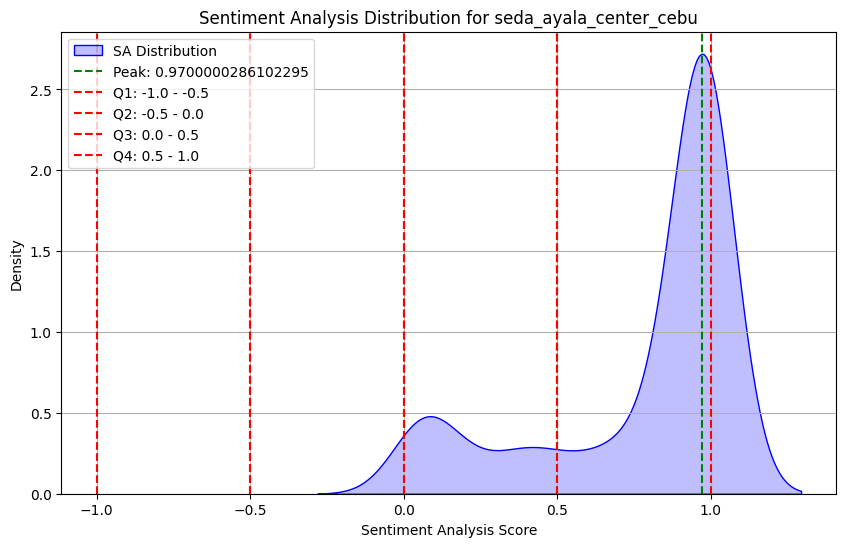

KS Statistic (Normal): 0.5077890057377452, P-value (Normal): 9.488260056522243e-88
KS Statistic (Uniform): 0.5703445111235528, P-value (Uniform): 8.234336482631032e-113


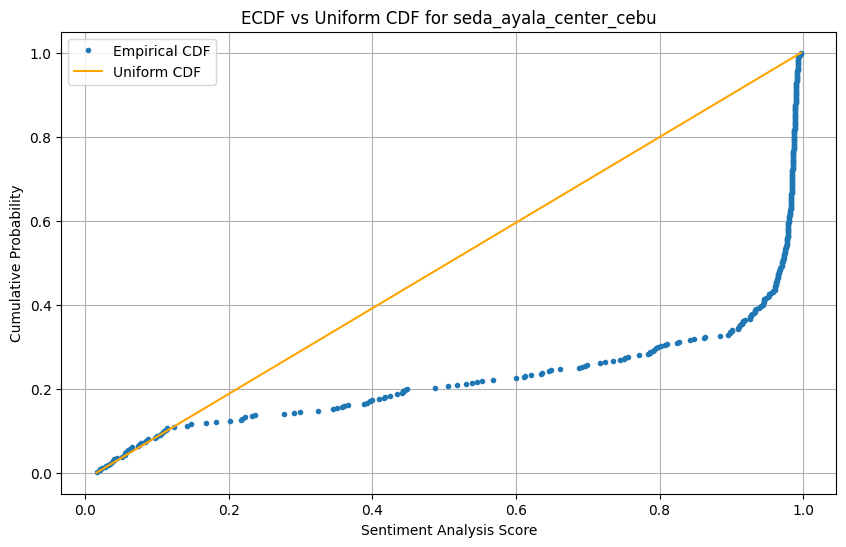

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


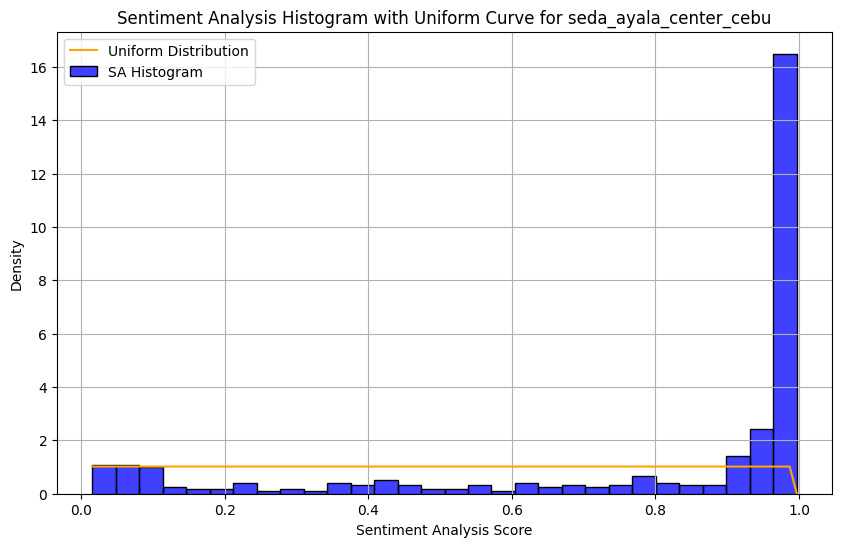

C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Processing hotel: dusit_thani_mactan
Number of records for dusit_thani_mactan: 444


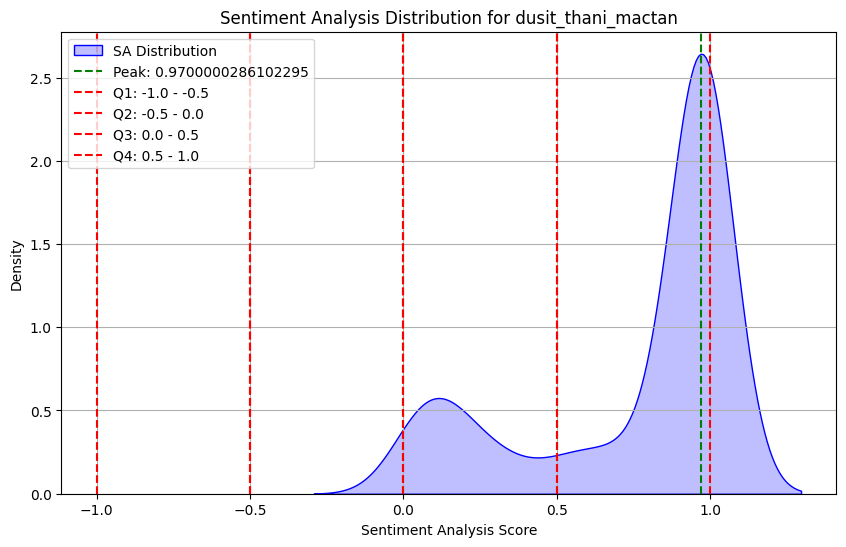

KS Statistic (Normal): 0.5035771987796659, P-value (Normal): 9.529945360827294e-105
KS Statistic (Uniform): 0.5645880054783177, P-value (Uniform): 4.25362082779398e-134


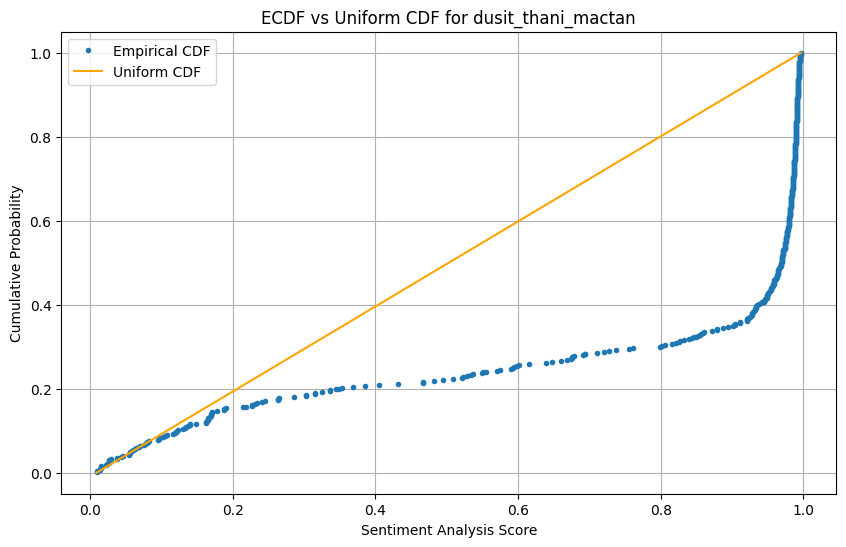

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


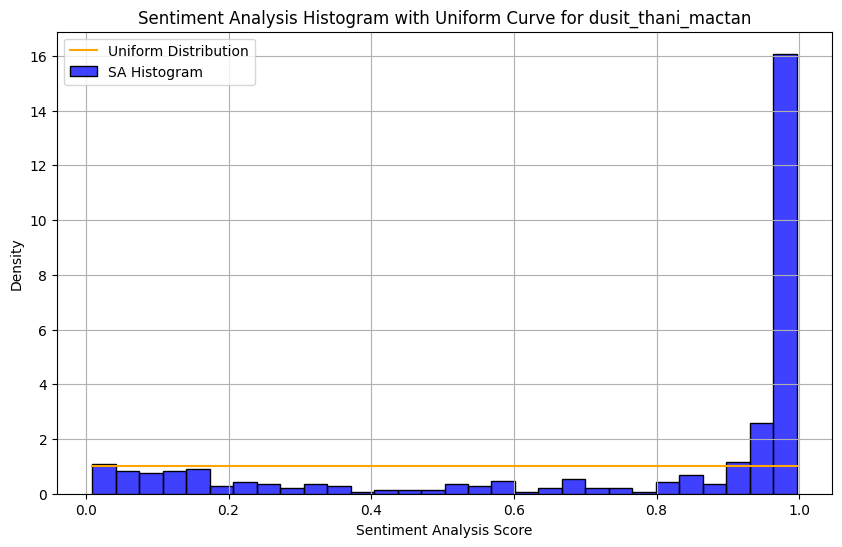

C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Processing hotel: waterfront_hotel_and_casino
Number of records for waterfront_hotel_and_casino: 279


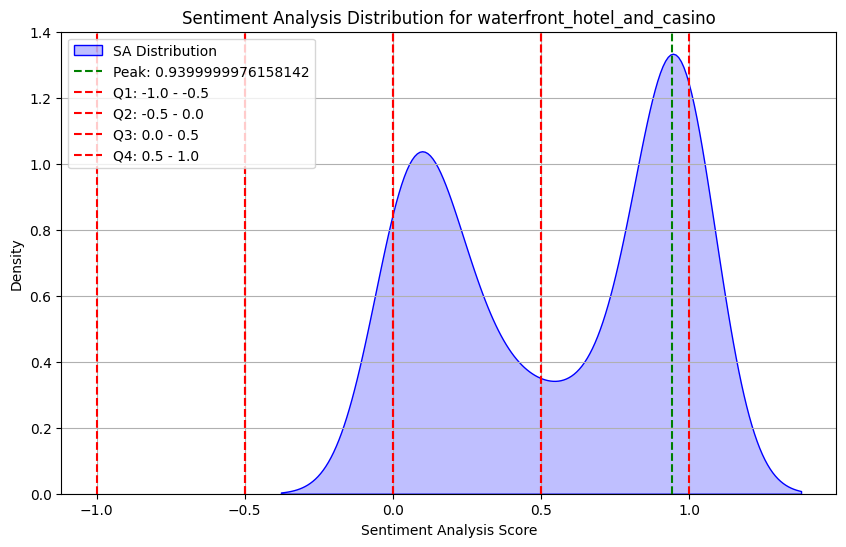

KS Statistic (Normal): 0.5026880602095488, P-value (Normal): 9.077974884227917e-66
KS Statistic (Uniform): 0.2778393713804129, P-value (Uniform): 1.557006260632929e-19


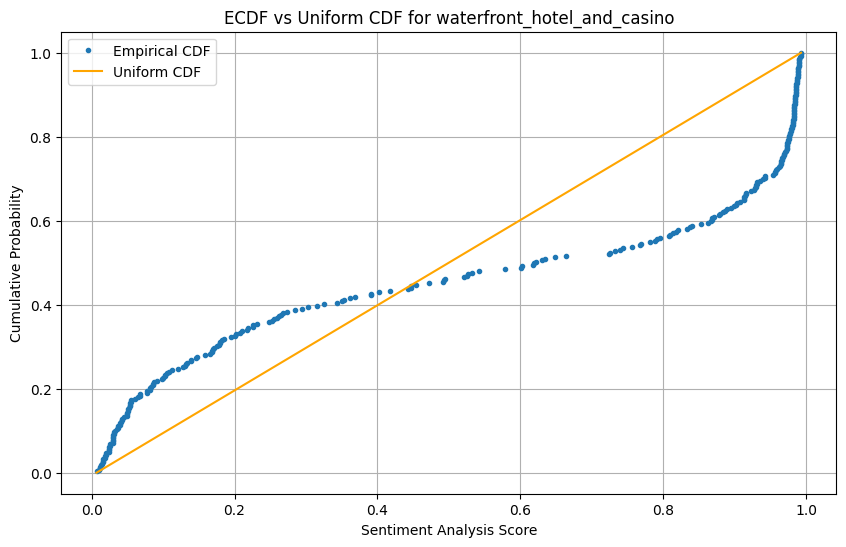

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


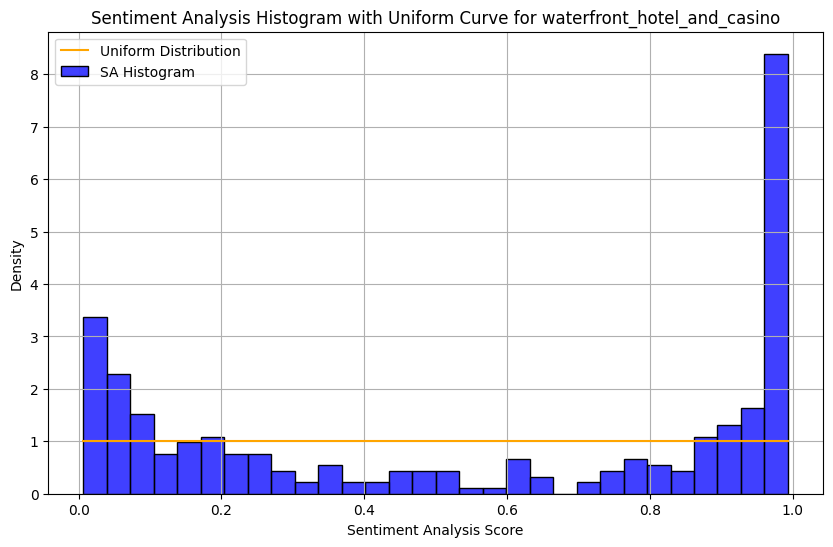

C:\Users\andyb\AppData\Local\Temp\ipykernel_12516\791118687.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Processing hotel: fairfield_by_marriott_cebu
Number of records for fairfield_by_marriott_cebu: 24


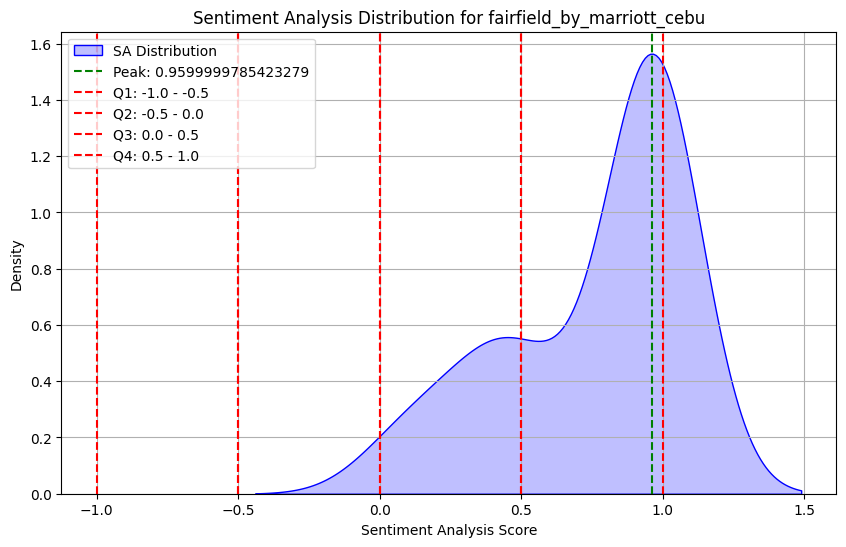

KS Statistic (Normal): 0.5417376017557834, P-value (Normal): 4.0002337201702383e-07
KS Statistic (Uniform): 0.5357577403386433, P-value (Uniform): 5.750531688971093e-07


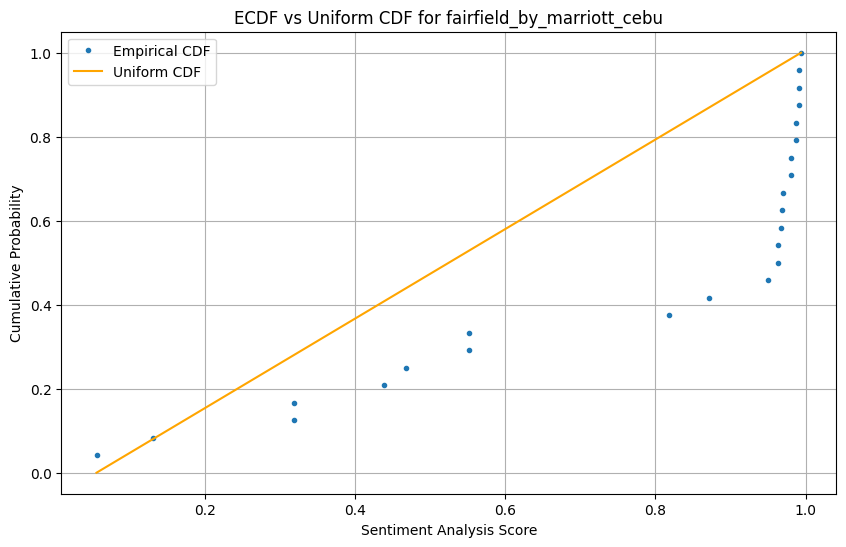

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


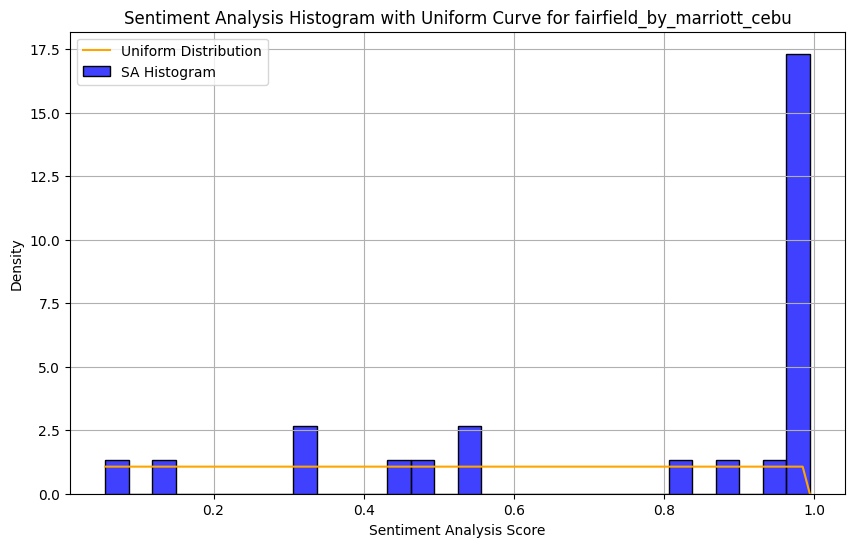

In [35]:
from scipy.stats import gaussian_kde, ks_1samp, norm, uniform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import glob

# Define a function to plot KDE, peak, perform KS test, and visualize
def plot_sa_distribution_uniform(df, hotel_name):
    if df.empty:
        print(f"No data available for hotel: {hotel_name}")
        return None

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['predicted_scores'], shade=True, color='blue', label='SA Distribution')

    # Calculate KDE and find peak
    kde = gaussian_kde(df['predicted_scores'])
    density_values = kde(df['predicted_scores'])
    peak_value = df['predicted_scores'].iloc[density_values.argmax()]
    plt.axvline(x=peak_value, linestyle='--', color='green', label=f'Peak: {round(peak_value, 2)}')

    # Add quartile lines
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} - {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(f'Sentiment Analysis Distribution for {hotel_name}')
    plt.xlabel('Sentiment Analysis Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform KS test against a normal distribution
    ks_statistic_norm, p_value_norm = ks_1samp(df['predicted_scores'], norm.cdf)
    print(f"KS Statistic (Normal): {ks_statistic_norm}, P-value (Normal): {p_value_norm}")

    # Perform KS test against a uniform distribution
    ks_statistic_uniform, p_value_uniform = ks_1samp(df['predicted_scores'], uniform(loc=df['predicted_scores'].min(), scale=df['predicted_scores'].max() - df['predicted_scores'].min()).cdf)
    print(f"KS Statistic (Uniform): {ks_statistic_uniform}, P-value (Uniform): {p_value_uniform}")

    # Visualization of the KS test
    # 1. ECDF Plot
    plt.figure(figsize=(10, 6))
    ecdf = np.sort(df['predicted_scores'])
    cdf_uniform = uniform(loc=df['predicted_scores'].min(), scale=df['predicted_scores'].max() - df['predicted_scores'].min()).cdf(ecdf)
    plt.plot(ecdf, np.arange(1, len(ecdf) + 1) / len(ecdf), marker='.', linestyle='none', label='Empirical CDF')
    plt.plot(ecdf, cdf_uniform, label='Uniform CDF', color='orange')
    plt.title(f'ECDF vs Uniform CDF for {hotel_name}')
    plt.xlabel('Sentiment Analysis Score')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Histogram with Uniform Curve
    plt.figure(figsize=(10, 6))
    sns.histplot(df['predicted_scores'], bins=30, kde=False, color='blue', label='SA Histogram', stat='density')
    x = np.linspace(df['predicted_scores'].min(), df['predicted_scores'].max(), 100)
    plt.plot(x, uniform.pdf(x, loc=df['predicted_scores'].min(), scale=df['predicted_scores'].max() - df['predicted_scores'].min()), color='orange', label='Uniform Distribution')
    plt.title(f'Sentiment Analysis Histogram with Uniform Curve for {hotel_name}')
    plt.xlabel('Sentiment Analysis Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    return peak_value

# Function to save the results
def save_results(hotel_name, peak_value):
    output_folder = "statistical_model_results"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create a file path for saving the results
    output_filename = os.path.join(output_folder, f"{hotel_name}_results.txt")

    # Determine which quartile the peak belongs to
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    peak_quartile = None
    for label, (start, end) in quartile_ranges.items():
        if start <= peak_value <= end:
            peak_quartile = label
            break

    # Open the file in write mode and save the results
    with open(output_filename, "w") as file:
        file.write(f"{hotel_name} Peak Value: {peak_value}\n")
        file.write(f"{hotel_name} Peak Quartile Classification: {peak_quartile}\n")

# Add the predicted probabilities to the scraped_data DataFrame
test_data['predicted_scores'] = y_pred_prob

# Ensure hotel_name is defined in the loop
for hotel_name in test_data['hotel'].unique():
    print(f"Processing hotel: {hotel_name}")
    hotel_data = test_data[test_data['hotel'] == hotel_name]
    print(f"Number of records for {hotel_name}: {len(hotel_data)}")
    peak_value = plot_sa_distribution_uniform(hotel_data, hotel_name)
    
    if peak_value is not None:
        # Save the results
        save_results(hotel_name, peak_value)